# Loan Eligibility Project

## Job Thomas Thekkekara - R00195427

In [4]:
# IMPORTING LIBRARIES
import pandas as pd
import numpy as np
import missingno as msno
import matplotlib.pyplot as plt
import seaborn as sns
from fancyimpute import IterativeImputer as MICE
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import pickle
%matplotlib inline

# Function Definitions

### Data Loading Function

In [7]:
def dataload_describe(df):
    print("------Shape of the Data------")
    print(df.shape)
    print("\n")
    print("------Data Information-------")
    print(df.info())
    print("\n")
    # data cleaning
    df['Loan_Status'] = df['Loan_Status'].replace({0:"No",1:"Yes"})
    df['Credit_History'] = df['Credit_History'].replace({0:"No",1:"Yes"})
    df.drop(['Loan_ID'],axis=1,inplace=True) # loan ID does not provide a ny valuable information. Hence dropped
    #print(df.head(1))
    print("------Data Description-------")
    print(df.describe())
    
    return data_loan

### Data Imputation Function - Mode, MICE, (Fig 3)

In [9]:
def missing_imputation(data_loan):
    msno.bar(data_loan) # complete cases plot
    plt.title("Missing values")
    plt.show()
    for col in data_loan.select_dtypes("object"):   # changing columns in to datatype category
        data_loan[col]=data_loan[col].astype("category")

    cat_cols = []                                   #selecting categorical columns
    for col in data_loan.select_dtypes("category"):
        cat_cols.append(col)

    cat_loan_df = data_loan[cat_cols].apply(lambda x:x.fillna(x.value_counts().index[0])) # missing values in categorical columns filled with mode
    print(" Number of missing values in categorical columns after imputation")
    print("\n")
    print(cat_loan_df.isnull().sum())  # checking for null values after replacement
    num_cols = []
    for col in data_loan.select_dtypes(["int64","float64"]): # selecting numerical columns
        num_cols.append(col)

    cols = list(num_cols)
    loan_num_df=pd.DataFrame(MICE(verbose=False).fit_transform(data_loan[num_cols])) #using MICE for imputation
    loan_num_df.columns=cols
    print(" Number of missing values in numerical columns after imputation")
    print("\n")
    print(loan_num_df.isnull().sum()) ## checking for null values after replacement

    data_loan[num_cols]=loan_num_df
    data_loan[cat_cols]=cat_loan_df
    return data_loan,cat_loan_df,loan_num_df

### Histograms of numerical data- Checking for skewness

In [27]:
def distribution_plots(data_loan):
    num_cols = []
    for col in data_loan.select_dtypes(["int64","float64"]): # selecting numerical columns
            num_cols.append(col) #appending to list
    sns.set()
    fig = plt. figure(figsize=(19, 10)) #setting figure size
    i = 1
    for col in data_loan[num_cols]: # for numerical columns in data
        plt. subplot (2,2, i)  #defining subplots
        sns. histplot (loan_num_df.loc[:, col]) #plotting histogram
        i=i+1
    plt.tight_layout
    plt.show()

### Checking for outliers in important columns - Removing invalid row

In [36]:
def outlier_detection(data_loan):
    income_cols = ['ApplicantIncome', 'CoapplicantIncome']
    sns.set (font_scale=1.8)
    fig = plt.figure(figsize=(17, 6)) #setting figure
    i = 1
    for col in data_loan[income_cols]: # for selected numerical columns in data
        plt. subplot (1,2,i) #defining subplots
        sns. stripplot (data_loan.loc[:,col]) #plotting scatter plots
        i=i+1
    plt.suptitle("Outliers Present across features", fontsize=16,y=1.01)
    plt.tight_layout()
    plt. show()
    print("Shape of the dataset")
    print(data_loan.shape)
    #data_loan[data_loan['ApplicantIncome']>50000] #checking data of extreme outliers
    data_loan=data_loan.drop([490],axis=0)  # removing row with invalida data. same values in loan amount and loan amount term
    print("\n")
    print("Shape of data set after removing a row")
    print(data_loan.shape)
    return data_loan

### Visualizations based on demographic information of customers (Fig 4)

In [44]:
def count_plots(data_loan):
    countY = len(data_loan[data_loan.Loan_Status == 'Yes']) # counting target column yes
    countN = len(data_loan[data_loan.Loan_Status == 'No'])  #counting target column No
    countNull = len(data_loan[data_loan.Loan_Status.isnull()]) #checking target column null

    print("Percentage of Approved: {:.2f}%".format((countY / (len(data_loan.Loan_Status))*100))) #percentage of Yes in target column
    print("Percentage of Rejected: {:.2f}%".format((countN / (len(data_loan.Loan_Status))*100))) #percentage of No in target column
    print("Missing values percentage: {:.2f}%".format((countNull / (len(data_loan.Loan_Status))*100)))
    print(data_loan['Loan_Status'].value_counts())

    fig, axs = plt.subplots(2,2, figsize=(30,17)) # setting figure
    
    sns.countplot(x='Gender',data=data_loan, ax=axs[0][0]) #countplot of gender
    axs[0][0].set_title("# of Gender",y=1.01)
    for i in axs[0][0].patches:
        axs[0][0].annotate(str(format(int(i.get_height()),'d')),(i.get_x(), i.get_height()*1.01))

    sns. countplot (x='Gender',data=data_loan,hue='Education' ,ax=axs[0][1]) #countplot of education
    axs[0][1]. set_title("Education of the Gender")
    for i in axs[0][1].patches:
        axs[0][1].annotate(str(format(int(i.get_height()), 'd')), (i.get_x(), i.get_height()*1.01))

    sns.countplot(x='Property_Area',data=data_loan,ax=axs[1][0]) #countplot of property area
    axs[1][0].set_title("# of Property Area",y=1.01)
    for i in axs[1][0].patches:
        axs[1][0].annotate(str(format(int(i.get_height()), 'd')),(i.get_x(), i.get_height()*1.01))

    sns.countplot(y='Property_Area',hue='Loan_Status',palette='pastel',edgecolor='.6',data=data_loan,ax=axs[1][1])   #countplot of loan status(target)                
    axs[1][1].set_title('Loan Status based on the Property Area')
    plt.show()

### Square root transformation of skewed data (Fig 5)

In [49]:
def transformation(data_loan):
    # Square Root Transformation

    data_loan.ApplicantIncome = np.sqrt(data_loan.ApplicantIncome)
    data_loan.CoapplicantIncome = np.sqrt(data_loan.CoapplicantIncome)
    data_loan.LoanAmount = np.sqrt(data_loan.LoanAmount)
    print("After applying square rrot transformation")
    print("\n")
    sns.set(style="darkgrid")
    fig, axs = plt.subplots(1, 3, figsize=(10, 5))

    sns.histplot(data=data_loan, x="ApplicantIncome", kde=True, ax=axs[0], color='green')
    sns.histplot(data=data_loan, x="CoapplicantIncome", kde=True, ax=axs[1], color='skyblue')
    sns.histplot(data=data_loan, x="LoanAmount", kde=True, ax=axs[2], color='orange');

    return data_loan

### Label encoding and get dummies for categorical data

In [52]:
def encoding(data_loan):
    # target column
    tgt_col = ['Loan Status']
    # Categorical cols
    category_names = data_loan.nunique()[data_loan.nunique() < 15].keys().tolist() #selecting categorical variables. checking number of categories less than 15 so that numerical information can be avoided
    category_names = [x for x in category_names if x not in tgt_col] # categorical variables except target column

    # Numerical cols
    num_cols = [i for i in data_loan.columns if i not in category_names + tgt_col] 

    # Binary cols
    bin_cols = data_loan.nunique()[data_loan.nunique()==2].keys().tolist()

    # Multi-cols
    multi_cols = [i for i in category_names if i not in bin_cols]

    # Label Encoding Binary cols
    le = LabelEncoder()
    for i in bin_cols:
        data_loan[i] = le.fit_transform(data_loan[i])

    # Duplicating cols for multi-value columns
    data_loan = pd.get_dummies(data=data_loan, columns = multi_cols)
    print("Encoding Completed")
    return data_loan

### Scaling of data using MinMaxScaler, Count Plot of Target (Fig 1 )

In [59]:
def scaling(data_loan):
    cont_features = []
    for features in data_loan.select_dtypes(include=['int64', 'float64']): #selecting numerical variables
        cont_features.append(features)

    ld_df=data_loan.copy(deep=True) # creating a copy of data frame
    minmax = MinMaxScaler()
    ld_df[cont_features]= minmax.fit_transform(ld_df[cont_features].values) # scaling numerical variables
    print("\n")
    print("Scaling of features completed")
    print("\n")
    #splitting data into x and y
    x = ld_df.drop(["Loan_Status"], axis=1)
    y = ld_df["Loan_Status"]
    sns.set_theme(style="darkgrid")
    sns.countplot(y=y, data=ld_df, palette="coolwarm") # count plot of target variable
    plt.ylabel('Loan Status')
    plt.xlabel('Total')
    plt.title("Count plot of loan status")
    plt.show()
    return x,y,ld_df

### Sampling of data using SMOTE (Fig 2)

In [58]:
def sampling(X_train, y_train,ld_df):
    X_train, y_train = SMOTE().fit_resample(X_train, y_train) # Applying SMOTE on traning data
    sns.set_theme(style="darkgrid")
    sns.countplot(y=y_train, data=ld_df, palette="coolwarm") # taking count plot of target variable in traning data
    plt.ylabel('Loan Status')
    plt.xlabel('Total')
    plt.title("Count plot of Loan Status after applying SMOTE")
    plt.show()
    return X_train, y_train

### Initial Model Training (Fig 6)

In [100]:
def initial_models(X_train, y_train):
    
    # Logistic Regression
    log_reg =  LogisticRegression(solver='liblinear',random_state=427)
    log_reg.fit(X_train, y_train)
    log_score = cross_val_score(log_reg, X_train, y_train,cv=5) # computing cross validation scores
    print("Logistic Regression: ", round(log_score.mean(),2)*100, "% accuracy score") #mean of scores as accuracy

    # Support Vector Machine
    svc = SVC(random_state=427)
    svc.fit(X_train, y_train)
    svc_score = cross_val_score(svc, X_train, y_train,cv=5)
    print("Support Vector Machine: ", round(svc_score.mean(),2)*100, "% accuracy score")

    # KNeighbors
    knn = KNeighborsClassifier()
    knn.fit(X_train, y_train)
    knn_score = cross_val_score(knn, X_train, y_train,cv=5)
    print("KNeighbors: ", round(knn_score.mean(),2)*100, "% accuracy score")

    # Decision Tree
    dcTree = DecisionTreeClassifier(random_state=427)
    dcTree.fit(X_train, y_train)
    dcTree_score = cross_val_score(dcTree, X_train, y_train, cv=5)
    print("Decision Tree: ", round(dcTree_score.mean(),2)*100, "% accuracy score")

    # Random Forest
    rf = RandomForestClassifier(random_state=427)
    rf.fit(X_train, y_train)
    rf_score = cross_val_score(rf, X_train, y_train, cv=5)
    print("Random Forest: ",  round(rf_score.mean(),2)*100, "% accuracy score")

### Hyper Prameter Tuning of Best Models (Fig 7)

In [153]:
def hyperparameter_tuning(X_train, y_train):
# using GridSearchCV to find the best parameters.
    # SVC
    svc_params = {'C':[0.1, 1, 10, 100],'gamma': [1, 0.1, 0.01, 0.001], 'kernel':['rbf','sigmoid']}
    grid_svc = GridSearchCV(SVC(probability=True), svc_params)
    grid_svc.fit(X_train, y_train)
    svc = grid_svc.best_params_
    

    # RandomForest
    
    rf_params = {'n_estimators':[100,200,300],'max_features':['auto','sqrt'],
                 "min_samples_leaf":[1, 2, 5, 10],"bootstrap":[True, False],
                "min_samples_split" : [2, 5, 10],
                "max_depth" : [5, 8, 15]}
    
    #rf_params = {'n_estimators':[100,200,300],'max_features':['auto','sqrt'],"min_samples_leaf":[1,2,4],"bootstrap":[True, False]}
    grid_rf = GridSearchCV(RandomForestClassifier(),rf_params)
    grid_rf.fit(X_train, y_train)
   
    print("Tuning Completed !")
    return grid_svc,grid_rf

### Loading and Saving Best Models

In [128]:
def save_model(model_svm,model_rf):
    
    with open('model_svm', 'wb') as files:
        pickle.dump(model_svm, files)  # Saving best model to Disk
        
    with open('model_rf', 'wb') as files:
        pickle.dump(model_rf, files)  # Saving best model to Disk
def import_model():
    with open('model_svm' , 'rb') as f:
        model_svm = pickle.load(f)    # Loading saved pre trained model 
        
    with open('model_rf' , 'rb') as f:
        model_rf = pickle.load(f)    # Loading saved pre trained model 
    return model_svm,model_rf

### Evalutaion of Models On Testing Data (Fig 8, Fig 9)

In [173]:
def model_evaluate(model_svm,model_rf,X_test,y_test):
    svm_pred= model_svm.predict(X_test) #predicting values on test data
    print("Test Accuracy of SVM Model = {:0.2f}%".format(accuracy_score(svm_pred,y_test)*100)) #computing accuracy
    print("Classification Report of SVM Model")
    print(classification_report(svm_pred,y_test))  #prining classification report
    print("\n")
    rf_pred= model_rf.predict(X_test)
    print("Test Accuracy of Random Forest Model = {:0.2f}%".format(accuracy_score(rf_pred,y_test)*100))
    print("Classification Report of Random Forest Model")
    print(classification_report(rf_pred,y_test))
    return svm_pred,rf_pred

### Model Evalution Plots (Fig 10, Fig 11, Fig 12)

In [175]:
def model_plots(X_test,y_test,svm_pred,rf_pred):
    # predict probabilities

    svc_proba = model_svm.predict_proba(X_test)
    rf_proba = model_rf.predict_proba(X_test)

    # roc_auc_score

    svc_auc = round(roc_auc_score(y_test,svc_proba[:,1])*100)
    rf_auc = round(roc_auc_score(y_test, rf_proba[:,1])*100)

    print("ROC_AUC_SCORE of models on Test Set\n")
    print("Support Vector Machine: ", svc_auc)
    print("Random Forest: ",rf_auc)

    # roc curve for models

    fpr2, tpr2, thresh2 = roc_curve(y_test, svc_proba[:,1],pos_label=1)
    fpr5, tpr5, thresh5 = roc_curve(y_test, rf_proba[:,1],pos_label=1)

    # roc curve for tpr = fpr 
    random_probs = [0 for i in range(len(y_test))]
    p_fpr, p_tpr, _ = roc_curve(y_test, random_probs, pos_label=1)

    plt.style.use('seaborn')

    # plot roc curves
    plt.plot(fpr2, tpr2, linestyle='--',color='green', label='SVC')
    plt.plot(fpr5, tpr5, linestyle='--',color='blue', label='Random Forest')
    plt.plot(p_fpr, p_tpr, linestyle='--', color='black')
    # title
    plt.title('ROC curve on Test Set')
    # x label
    plt.xlabel('False Positive Rate')
    # y label
    plt.ylabel('True Positive rate')

    plt.legend(loc='best')

    plt.show()
    #printing confusion matrix
    print("\n")
    print("Confusion Matrix")
    rf_cm = confusion_matrix(y_test, svm_pred)
    plt.title("SVM Confusion Matrix")
    sns.heatmap(rf_cm, cbar=False, cmap="Blues",annot=True, annot_kws={'size':16},fmt='g')
    plt.show()
    rf_cm = confusion_matrix(y_test, rf_pred)
    plt.title("Random Forest Confusion Matrix")
    sns.heatmap(rf_cm, cbar=False, cmap="Blues",annot=True, annot_kws={'size':16},fmt='g')
    plt.show()

# Main Execution of Program Starts Here

In [8]:
data_loan = pd.read_csv('C:\\Users\\bless\\Desktop\\MTU-Sem2\\Applied ML\\Assignment3\\Loan_Status.csv') #reading data
data_loan= dataload_describe(data_loan)

------Shape of the Data------
(614, 13)


------Data Information-------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Loan_ID            614 non-null    object 
 1   Gender             601 non-null    object 
 2   Married            611 non-null    object 
 3   Dependents         599 non-null    object 
 4   Education          614 non-null    object 
 5   Self_Employed      582 non-null    object 
 6   ApplicantIncome    614 non-null    int64  
 7   CoapplicantIncome  614 non-null    float64
 8   LoanAmount         614 non-null    int64  
 9   Loan_Amount_Term   600 non-null    float64
 10  Credit_History     564 non-null    float64
 11  Property_Area      614 non-null    object 
 12  Loan_Status        614 non-null    int64  
dtypes: float64(3), int64(3), object(7)
memory usage: 62.5+ KB
None


------Data Description-------
   

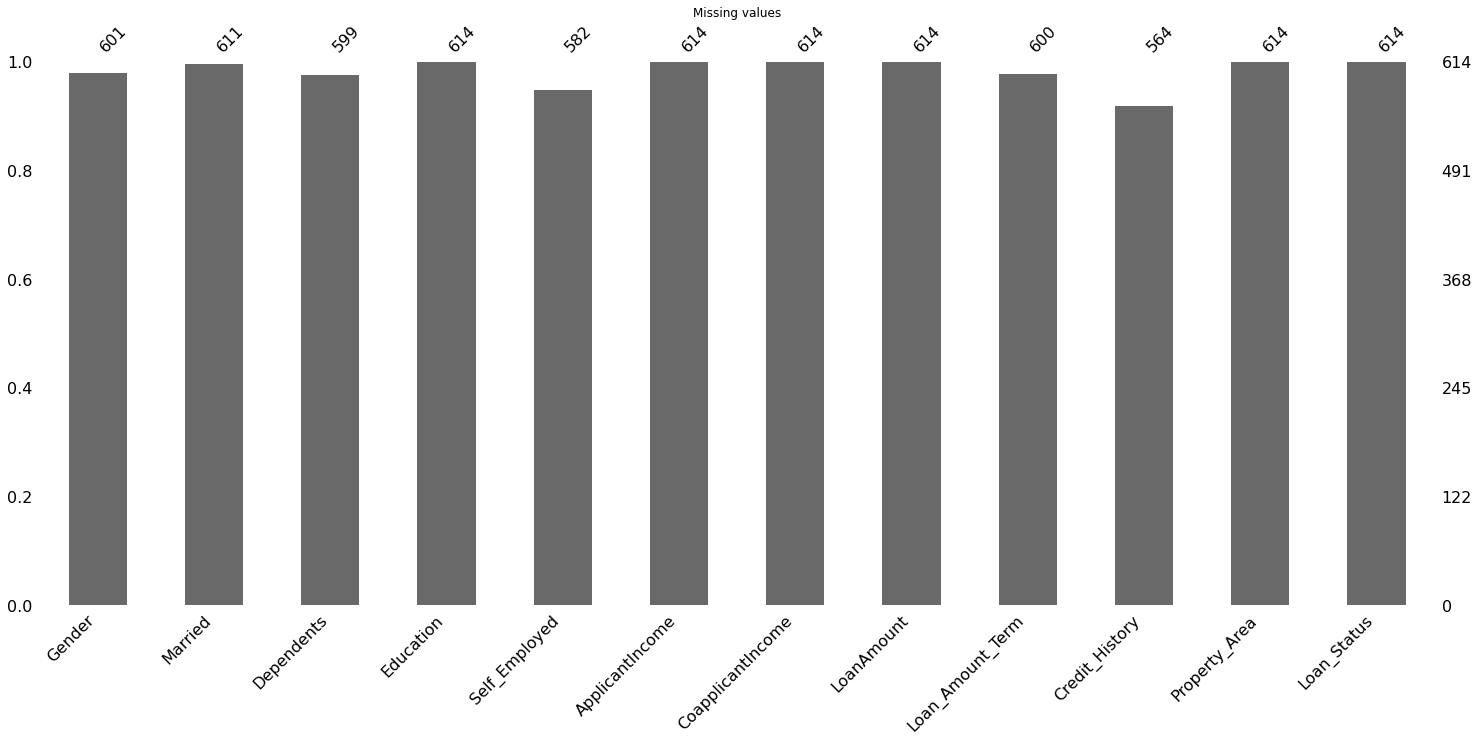

 Number of missing values in categorical columns after imputation


Gender            0
Married           0
Dependents        0
Education         0
Self_Employed     0
Credit_History    0
Property_Area     0
Loan_Status       0
dtype: int64
 Number of missing values in numerical columns after imputation


ApplicantIncome      0
CoapplicantIncome    0
LoanAmount           0
Loan_Amount_Term     0
dtype: int64


In [10]:
data_loan,cat_loan_df,loan_num_df= missing_imputation(data_loan)

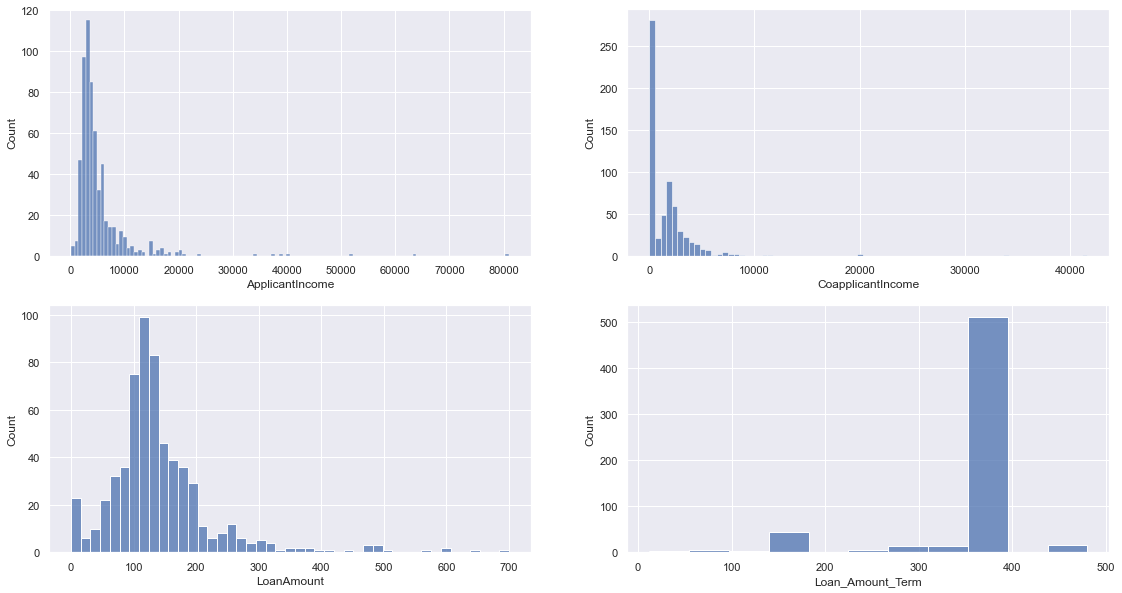

In [89]:
distribution_plots(data_loan)

C:\Users\bless\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\bless\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


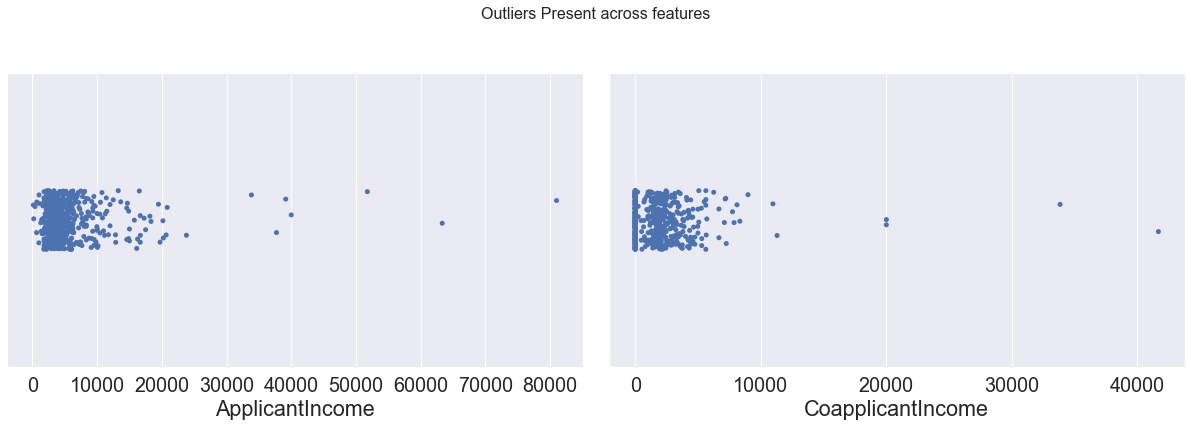

Shape of the dataset
(614, 12)


Shape of data set after removing a row
(613, 12)


In [90]:
data_loan=outlier_detection(data_loan)

Percentage of Approved: 68.68%
Percentage of Rejected: 31.32%
Missing values percentage: 0.00%
Yes    421
No     192
Name: Loan_Status, dtype: int64


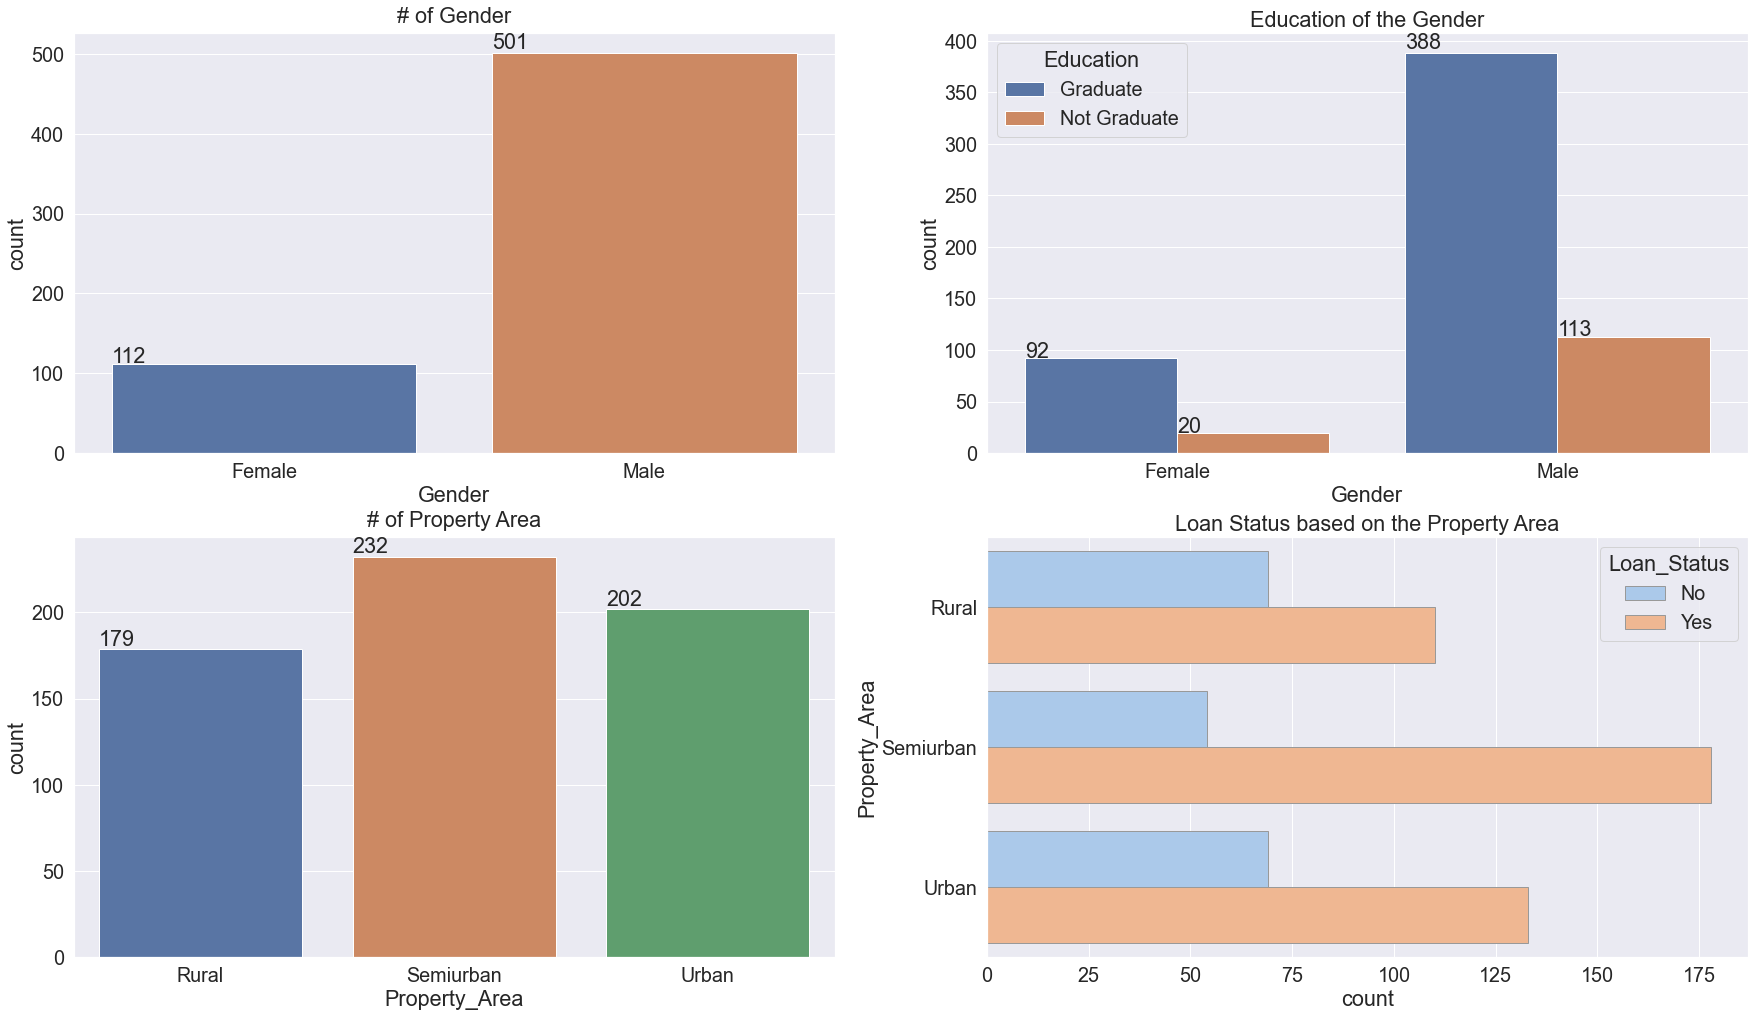

In [91]:
count_plots(data_loan)

After applying square rrot transformation




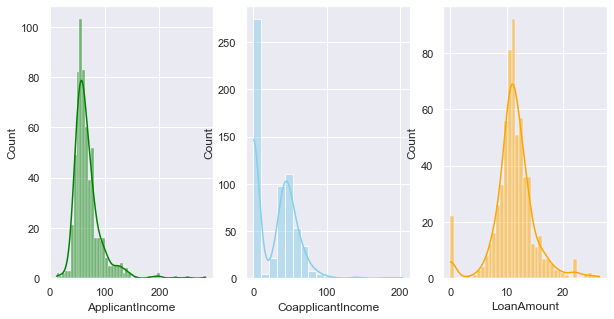

In [92]:
data_loan=transformation(data_loan)

Encoding Completed


Scaling of features completed




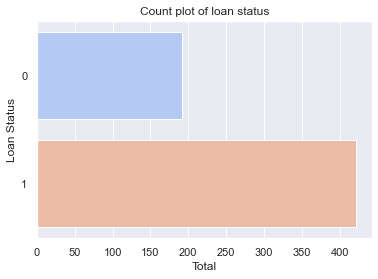

In [93]:
data_loan=encoding(data_loan)
x,y,ld_df=scaling(data_loan)

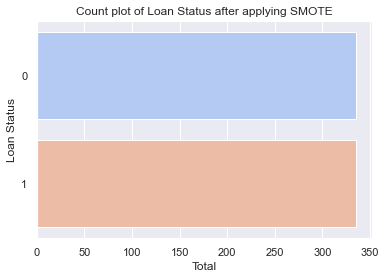

(670, 16)
(123, 16)
(670,)
(123,)


In [109]:
X_train,X_test,y_train,y_test=train_test_split(x,y,test_size=0.2,random_state=427)
X_train, y_train=sampling(X_train, y_train,ld_df)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

In [111]:
initial_models(X_train, y_train)

Logistic Regression:  74.0 % accuracy score
Support Vector Machine:  77.0 % accuracy score
KNeighbors:  76.0 % accuracy score
Decision Tree:  76.0 % accuracy score
Random Forest:  82.0 % accuracy score


In [151]:
model_svm,model_rf=hyperparameter_tuning(X_train, y_train)

Tuning Completed !


In [126]:
save_model(model_svm,model_rf)

In [154]:
model_svm,model_rf=import_model()

In [155]:
model_rf.best_params_

{'bootstrap': True,
 'max_depth': 15,
 'max_features': 'sqrt',
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 200}

In [171]:
model_svm.best_params_

{'C': 1, 'gamma': 1, 'kernel': 'rbf'}

In [176]:
svm_pred,rf_pred=model_evaluate(model_svm,model_rf,X_test,y_test)

Test Accuracy of SVM Model = 72.36%
Classification Report of SVM Model
              precision    recall  f1-score   support

           0       0.54      0.54      0.54        37
           1       0.80      0.80      0.80        86

    accuracy                           0.72       123
   macro avg       0.67      0.67      0.67       123
weighted avg       0.72      0.72      0.72       123



Test Accuracy of Random Forest Model = 75.61%
Classification Report of Random Forest Model
              precision    recall  f1-score   support

           0       0.51      0.61      0.56        31
           1       0.86      0.80      0.83        92

    accuracy                           0.76       123
   macro avg       0.69      0.71      0.70       123
weighted avg       0.77      0.76      0.76       123



ROC_AUC_SCORE of models on Test Set

Support Vector Machine:  73
Random Forest:  77


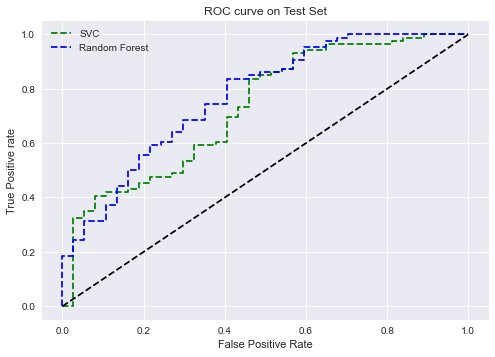



Confusion Matrix


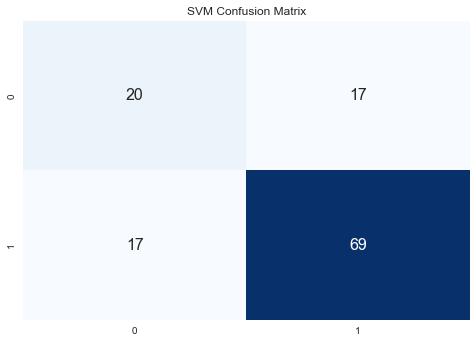

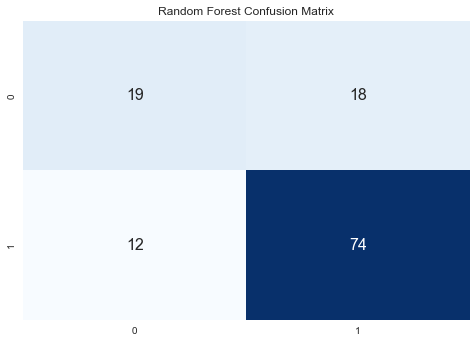

In [177]:
model_plots(X_test,y_test,svm_pred,rf_pred)